In [20]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from skimage.feature import match_template

In [2]:
movie = tifffile.imread('data/caiman_data.tif')
movie.shape

(3000, 170, 170)

### **Understanding Local Motion and Preparing for Non-Rigid Correction**

While rigid motion correction aligns entire frames using a single transformation, many calcium imaging datasets exhibit more complex distortions that vary across space. These local distortions—such as shearing, warping, or bending—are caused by uneven tissue movement, breathing artifacts, or gradual drift. Non-rigid motion correction addresses these challenges by dividing each frame into smaller regions and aligning them independently. In this section, students will explore how to recognize local motion artifacts, distinguish them from global shifts, and prepare the dataset for local alignment. This preparation involves selecting a suitable reference frame, dividing the image into patches, and ensuring consistent intensity scaling. These foundational steps set the stage for learning and implementing non-rigid motion correction in later sections.

**Sub-sections:**
- Identify non-rigid motion in calcium imaging movies  
- Understand the need for grid-based (local) correction  
- Divide frames into manageable patches for local analysis  
- Normalize intensity and prepare reference patches  

**Exercise** Visualize motion in time

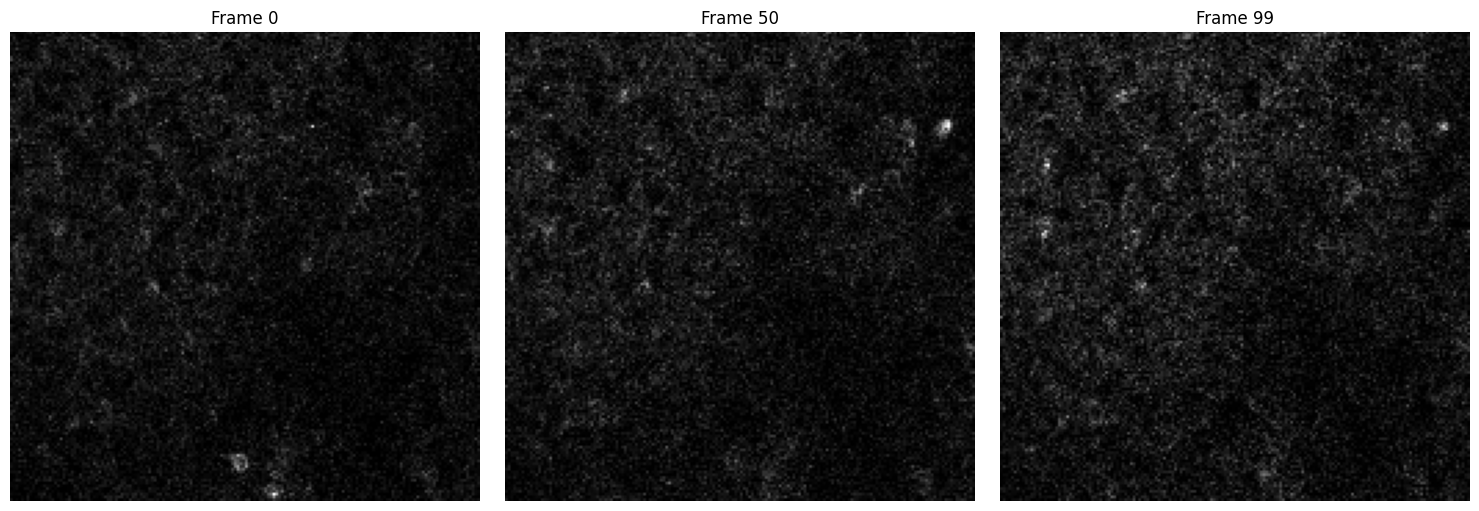

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, frame_idx in enumerate([0, 50, 99]):
    axes[i].imshow(movie[frame_idx], cmap='gray')
    axes[i].set_title(f"Frame {frame_idx}")
    axes[i].axis('off')
plt.tight_layout()

**Exercise** Inspect local motion

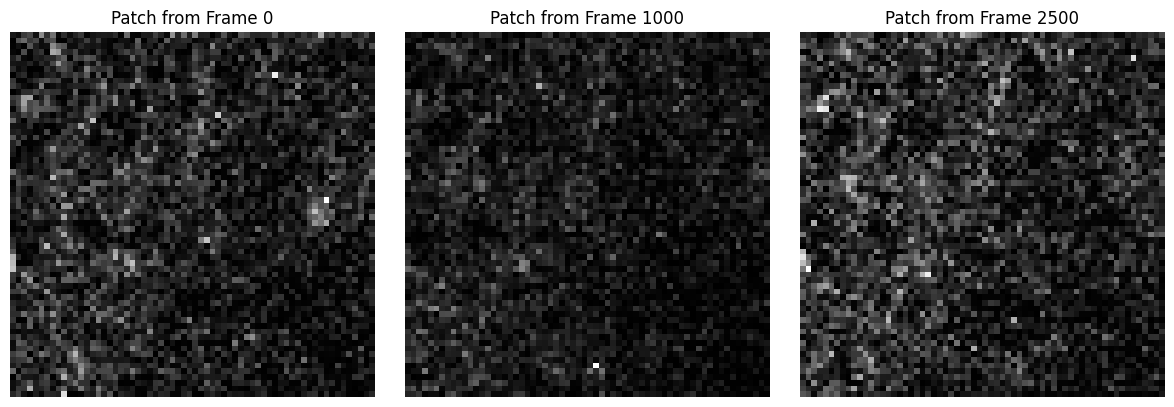

In [6]:
h, w = movie.shape[1:]
y0, x0 = h//2 - 32, w//2 - 32

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, frame_idx in enumerate([0, 1000, 2500]):
    patch = movie[frame_idx, y0:y0+64, x0:x0+64]
    axes[i].imshow(patch, cmap='gray')
    axes[i].set_title(f"Patch from Frame {frame_idx}")
    axes[i].axis('off')
plt.tight_layout()

**Exercise** Draw a grid

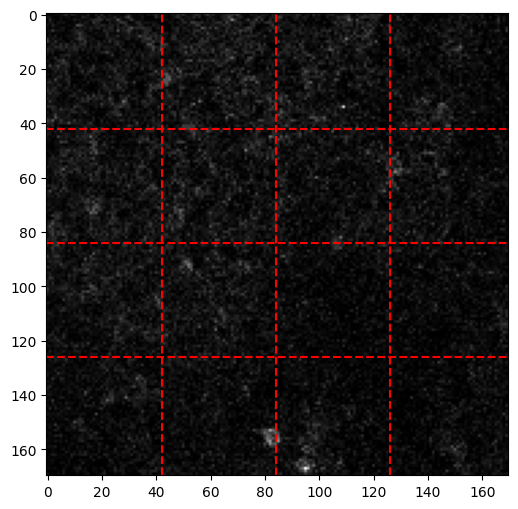

In [8]:
frame = movie[0]
grid_rows, grid_cols = 4, 4
patch_h, patch_w = frame.shape[0] // grid_rows, frame.shape[1] // grid_cols

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(frame, cmap='gray')
for i in range(1, grid_rows):
    ax.axhline(i * patch_h, color='red', linestyle='--')
for j in range(1, grid_cols):
    ax.axvline(j * patch_w, color='red', linestyle='--')

**Exercise** Annotate grid locations

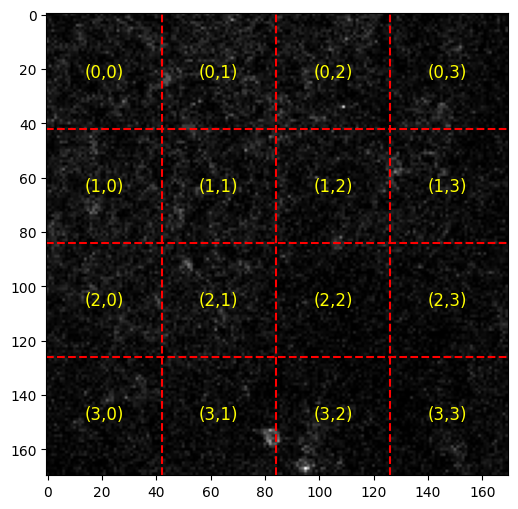

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(frame, cmap='gray')
for i in range(grid_rows):
    for j in range(grid_cols):
        y = i * patch_h + patch_h // 2
        x = j * patch_w + patch_w // 2
        ax.text(x, y, f"({i},{j})", color='yellow', ha='center', va='center', fontsize=12)
for i in range(1, grid_rows):
    ax.axhline(i * patch_h, color='red', linestyle='--')
for j in range(1, grid_cols):
    ax.axvline(j * patch_w, color='red', linestyle='--')

**Exercise** Patch extraction

In [10]:
patch_size = 32
h, w = frame.shape
patches = []

for i in range(0, h, patch_size):
    for j in range(0, w, patch_size):
        patch = frame[i:i+patch_size, j:j+patch_size]
        patches.append(patch)

len(patches)

36

**Exercise** Extract refernce patch

In [12]:
ref = np.median(movie, axis=0)
ref_norm = (ref - ref.min()) / (ref.max() - ref.min())

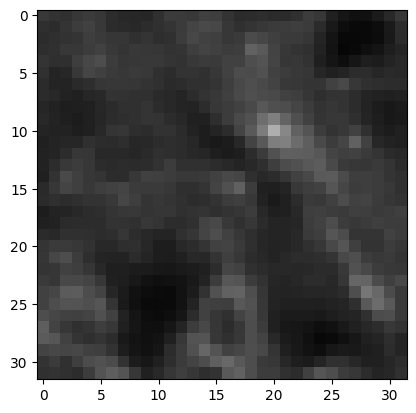

In [14]:
row, col = 1, 1
y0 = row * patch_size
x0 = col * patch_size
ref_patch = ref_norm[y0:y0+patch_size, x0:x0+patch_size]
plt.imshow(ref_patch, cmap='gray', vmin=0, vmax=1)


### **Estimating Local Displacement Fields Using Template Matching**

To correct for non-rigid motion, we must first understand how different parts of the image move relative to a stable reference. Instead of estimating a single shift per frame, we now estimate a displacement vector for each local patch. This section introduces us to the concept of a displacement field—a grid of local motion estimates—and teaches how to compute these shifts using patch-wise template matching. By comparing patches in each frame to their corresponding region in the reference image, we can capture the unique local motion in each area. We will learn how to implement this idea using normalized cross-correlation, identify meaningful motion vectors, and begin constructing a smooth and reliable map of frame-wise local motion.

**Sub-sections:**
- Understand the concept of displacement fields  
- Implement patch-wise motion estimation  
- Use normalized cross-correlation or phase correlation locally  
- Store and visualize local displacement vectors  

**Exercise** Select two frames and extract a patch

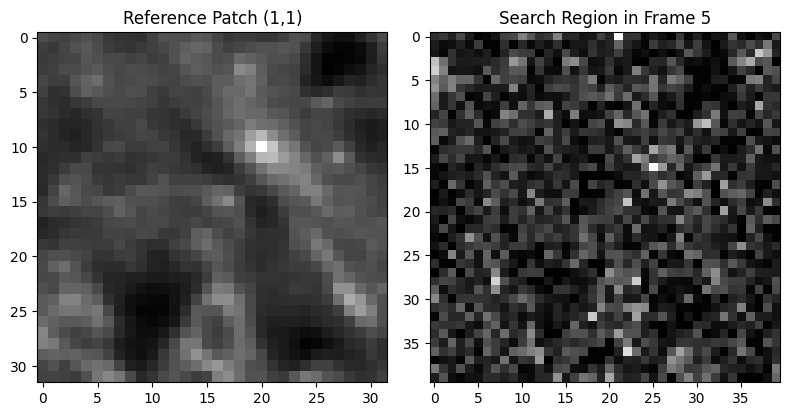

In [25]:
moving_frame = movie[5]

patch_size = 32
row, col = 1, 1
y0 = row * patch_size
x0 = col * patch_size

ref_patch = ref[y0:y0+patch_size, x0:x0+patch_size]
moving_patch = moving_frame[y0-4:y0+patch_size+4, x0-4:x0+patch_size+4] 

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(ref_patch, cmap='gray')
axes[0].set_title("Reference Patch (1,1)")

axes[1].imshow(moving_patch, cmap='gray')
axes[1].set_title("Search Region in Frame 5")

plt.tight_layout()

**Exercise** Perform template matching

In [21]:
result = match_template(moving_patch, ref_patch, pad_input=True)
ij = np.unravel_index(np.argmax(result), result.shape)
y_peak, x_peak = ij

dy = y_peak - 4 
dx = x_peak - 4

print(f"Estimated shift: dy = {dy}, dx = {dx}")

Estimated shift: dy = 16, dx = 17


**Exercise** Visualize the match result

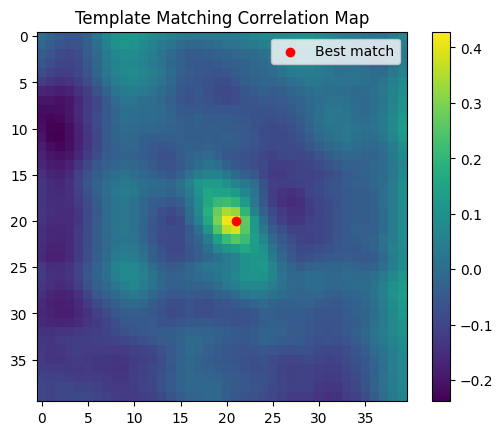

In [22]:
plt.imshow(result, cmap='viridis')
plt.title("Template Matching Correlation Map")
plt.colorbar()
plt.scatter(x_peak, y_peak, color='red', label='Best match')
plt.legend()

**Demo** Repeat for all patches

In [28]:
displacements = []
margin = 4

for i in range(4):
    for j in range(4):
        y0 = i * patch_size
        x0 = j * patch_size
        
        if y0 - margin < 0 or x0 - margin < 0 or y0 + patch_size + margin > h or x0 + patch_size + margin > w:
            continue
        
        ref_patch = ref[y0:y0+patch_size, x0:x0+patch_size]
        moving_patch = moving_frame[y0 - margin:y0 + patch_size + margin,
                                    x0 - margin:x0 + patch_size + margin]

        result = match_template(moving_patch, ref_patch, pad_input=True)
        y_peak, x_peak = np.unravel_index(np.argmax(result), result.shape)
        dy = y_peak - margin
        dx = x_peak - margin

        displacements.append((i, j, dy, dx))

print("Displacements (row, col, dy, dx):")
for d in displacements:
    print(d)


Displacements (row, col, dy, dx):
(1, 1, np.int64(16), np.int64(17))
(1, 2, np.int64(16), np.int64(16))
(1, 3, np.int64(16), np.int64(17))
(2, 1, np.int64(16), np.int64(17))
(2, 2, np.int64(16), np.int64(16))
(2, 3, np.int64(-4), np.int64(30))
(3, 1, np.int64(16), np.int64(17))
(3, 2, np.int64(19), np.int64(4))
(3, 3, np.int64(13), np.int64(28))


**Demo** Visualize displacement field

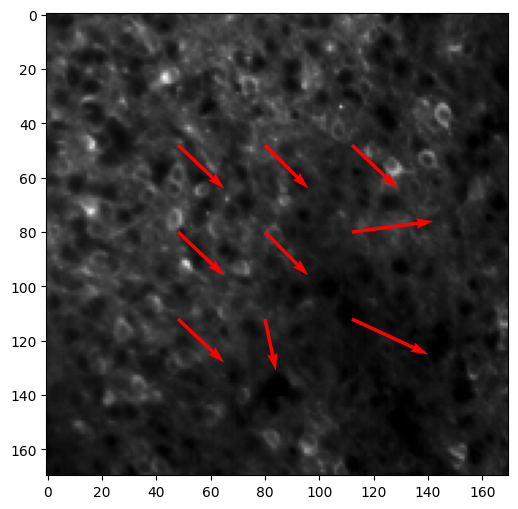

In [33]:
Y, X, U, V = [], [], [], []

for (i, j, dy, dx) in displacements:
    y_center = i * patch_size + patch_size // 2
    x_center = j * patch_size + patch_size // 2
    Y.append(y_center)
    X.append(x_center)
    U.append(dx)
    V.append(dy)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(ref, cmap='gray')
ax.quiver(X, Y, U, V, color='red', angles='xy', scale_units='xy', scale=1)

### **Warping Frames with Local Displacement Fields**

Once local motion estimates have been collected, the next step is to use them to correct the movie. This involves warping each frame based on its unique displacement field, such that every local region aligns with its reference position. In this section, we will apply image transformations to each patch or sub-region in the frame and learn how to smoothly interpolate between them to avoid artificial seams. By combining patch-wise warping with grid-based interpolation, we can generate a fully corrected frame that accounts for local variability in motion.

**Sub-sections:**
- Learn image warping based on displacement vectors  
- Use grid interpolation to apply local motion correction  
- Avoid discontinuities between patches with interpolation or smoothing  
- Create a motion-corrected movie stack using local deformations  

**Exercise** Create and empty canvas for crrected frame

In [34]:
h, w = frame.shape
corrected = np.zeros_like(frame)

**Exercise** Apply local shifts patch-by-patch

In [36]:
patch_size = 32
moving_frame = movie[0]  

for (i, j, dy, dx) in displacements:
    y0 = i * patch_size
    x0 = j * patch_size

    patch = moving_frame[y0:y0+patch_size, x0:x0+patch_size]
    shifted_patch = np.roll(patch, shift=(dy, dx), axis=(0, 1))
    corrected[y0:y0+patch_size, x0:x0+patch_size] = shifted_patch

**Exercise** Display original and corrected frame

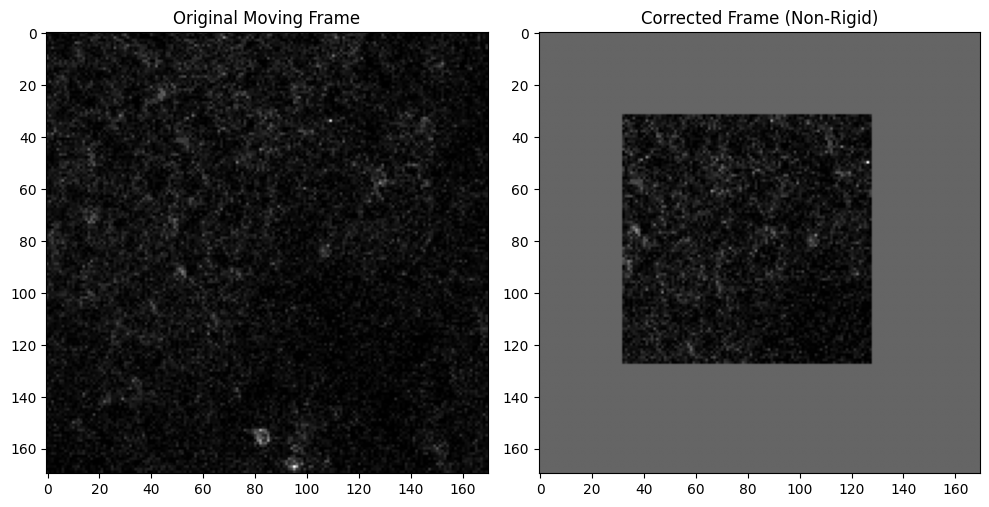

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(moving_frame, cmap='gray')
axes[0].set_title("Original Moving Frame")

axes[1].imshow(corrected, cmap='gray')
axes[1].set_title("Corrected Frame (Non-Rigid)")

plt.tight_layout()

### **Assessing the Effectiveness of Non-Rigid Motion Correction**

After performing non-rigid motion correction, it is critical to evaluate whether the procedure has truly improved image stability. This final section introduces multiple strategies for validating the correction: visual inspection, motion summary projections, and displacement field visualization. We will learn to compare raw and corrected images, examine residual motion across frames, and plot displacement vectors to understand the extent of local correction. These evaluation tools help determine whether non-rigid correction offers a meaningful improvement over rigid methods and prepare the data for further analysis, such as segmentation or signal extraction.

**Sub-sections:**
- Visualize raw versus non-rigid corrected movies  
- Compare rigid versus non-rigid summary projections  
- Create displacement vector field plots and residual maps  
- Prepare the corrected data for segmentation and signal extraction  